<a href="https://colab.research.google.com/github/isa-ulisboa/greends-pml/blob/main/assignments/assignment_march_24_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practical Machine Learning

Masters in Green Data Science, ISA/ULisboa, 2022-2023

Instructor: Manuel Campagnolo mlc@isa.ulisboa.pt

Assignment due March 24th, 2023

Estimated time to complete the assignment: 2-3 hours.



---



The script below implements the perceptron model for the Titanic tabular data set as discussed in class.


The two parts of the assignment are:

1. Try changing meta-parameters like the batch size, number of epochs, learning rate, or pre-processing of the numerical data, to try to get the least possible error rate over the validation set. For instance, one possible result with the percepton model is the following, with some set of meta-parameters:

<img src="https://drive.google.com/uc?export=view&id=1eiMlyGuLQ0mA1tUw0QNWhTkbHCSqfBU9" width="600" >

2. Adapt the script below to implement a multiple layer *feed-forward neural network*, as described at the end of [ML_overview_with_examples.ipynb](ML_overview_with_examples.ipynb). In order to do this easily, use and adapt if needed the functions defined in the last part of the notebook [Lesson5_edited_for_colab_linear_model_and_neural_net_from_scratch.ipynb](Lesson5_edited_for_colab_linear_model_and_neural_net_from_scratch.ipynb). It is recommend to use a GPU if there are several hidden layers or the number of epochs is large.
Then, do as in part 1 of the assigment and try changing the architecture of the network as well as the other meta parameters to obtain a model that performs well over the validation data set. You can describe the architecture by the number of neurons in each hiden layer (from the first to the last).


You should write a short report (one single `pdf` file for both parts), where you indicate, for part 1 and part 2, the hyper-parameters and the confusion matrix (by row: true negatives, false positives, false negatives, true positives) as  in the following example. You only need to report three or four results for each part, enough to illustrate some pattern that indicate how you can improve your results. Sort the rows in each table by overall performance.

You can add some short comments  for each part.

If you wish, you can use a data set other than the Titanic data set. In that case, please add a brief description of the variables and labels.

If you can, **please print** a hard copy of your report and bring it to the class. If you're not able to print, then you may send the report by email (subject: assignment PML). 

---
(This is an example of a report: you should choose your own meta-parameters)

Name: _______________________

Date: ______________________________

PART 1 (perceptron)

|Batch size | Learning rate | Epochs | Pre-processing| TN, FP, FN, TP| Error_rate|
|-||||||
|20|0.1|20|Added 1s + standardized | 102, 3, 66, 8|0.3855|
|10|0.1|20|Added 1s + standardized | 105, 0, 70, 4|...|
|...||||||

Comments: ____


PART 2 (feed-forward NN)

|NN architecture|Batch size | Learning rate | Epochs | Pre-processing| TN, FP, FN, TP|Error_rate|
|-|||||||
|10,5,10|20|0.1|300|standardized | 88,17,21,53|0.212|
|10,10|20|0.1|20|standardized | 102, 3, 66, 8|...|
|...|||||||

Comments: ____

---


Code to adapt and execute (please *do not* include the code in your report)

In [ ]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
torch.manual_seed(42)

B=20 # batch size
lr = 0.1 # learning rate
iter=20 # number epochs

############################################ Reading Titanic numerical data, i.e., X and y
var_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
path=Path('/content/drive/MyDrive/AAA/Lesson_5/titanic_data') # adapt to your path
X,y=torch.load(path/'titanic_tensor_data_set.ts') # these values are not yet normalized
y=y[:,None] # to turn it into a column vector

##################################### Create train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

############################################## Ordinary least squares solution with 0.5 threshold
# variables to keep to avoid linear dependencies
var_keep=['Age', 'SibSp', 'Parch', 'LogFare', 'Sex_male',  'Pclass_1', 'Pclass_2',  'Embarked_C', 'Embarked_Q']
keep=np.isin(var_names,var_keep) # boolean list
# 
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train[:,keep], y_train)
print('coefficients MLR:',reg.intercept_,reg.coef_)
y_pred=reg.predict(X_valid[:,keep])
disp = ConfusionMatrixDisplay(confusion_matrix(y_valid,(y_pred>0.5)))
disp.plot()
plt.show()

####################################################### Gradient Descent
# if you want to standardize X and include an additional additive coefficient to the model:
if False: 
  means = X.mean(dim=1, keepdim=True)
  stds = X.std(dim=1, keepdim=True)
  X=normalized_data = (X - means) / stds
  # add column
  ones=torch.ones(X.shape[0]).reshape(X.shape[0],1)
  X=torch.cat((ones,X),1)
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# initial weights
def init_coeffs(n_coeff): return (torch.rand(n_coeff,1)-0.5).requires_grad_() # creates a column matrix

# defining the function for prediction: the output is a vector of size=nrows(X)
def calc_preds(coeffs,X): return  torch.sigmoid(X@coeffs) # using matrix multiplication (aka matmul)

# Computing MSE loss for one batch of exemples: the output is a scalar
def calc_loss_from_labels(y_pred, y): return torch.mean((y_pred - y) ** 2)

# update coeffs
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    # zerofy gradients (because they add up)
    coeffs.grad.zero_()

# compute initial weights as a column matrix
n_coeff = X_train.shape[1] # number of columns of X, or X_train, or X_valid
coeffs = init_coeffs(n_coeff)

# create lists to store losses for each epoch
training_losses=[]; validation_losses=[]

# epochs
for i in range(iter):
  # calculating loss as in the beginning of an epoch and storing it
    y_pred = calc_preds(coeffs,X_train)
    training_losses.append(calc_loss_from_labels(y_pred, y_train).tolist())
    y_pred = calc_preds(coeffs,X_valid)
    validation_losses.append(calc_loss_from_labels(y_pred, y_valid).tolist())
    # mini-batch gradient descent: weight are updated after each batch
    for idx_start in np.arange(0,X_train.shape[0],B):
        # create batch
        batch_X=X_train[idx_start:(idx_start+B),:]
        batch_y=y_train[idx_start:(idx_start+B):]
        # making a prediction in forward pass
        y_pred = calc_preds(coeffs,batch_X)
        # calculating the loss between predicted and actual values
        loss = calc_loss_from_labels(y_pred, batch_y)
        # compute gradient
        loss.backward()
        with torch.no_grad():
            # update coeffs
            update_coeffs(coeffs, lr)

# predictions and confusion matrix
print('coefficients GD:',torch.flatten(coeffs.requires_grad_(False)))
y_pred=calc_preds(coeffs,X_valid)
disp = ConfusionMatrixDisplay(confusion_matrix(y_valid,(y_pred>0.5)))
disp.plot()
plt.show()

# plot losses along epochs
plt.plot(training_losses, '-g',  validation_losses, '-r')
plt.gca().legend(('train','validation'))
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('loss (MSE)')
#plt.title("Train (green) and validation (red) losses")
plt.show()

### Part 2

coefficients MLR: [0.5854171] [[-0.0042809  -0.04922816 -0.03017007  0.05970862 -0.5046148   0.22423151
   0.1791499   0.07168674  0.04639366]]


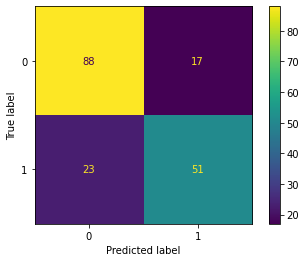

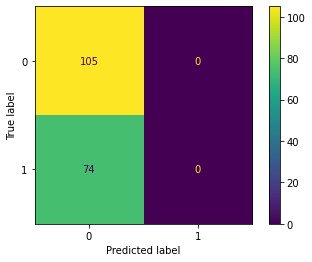

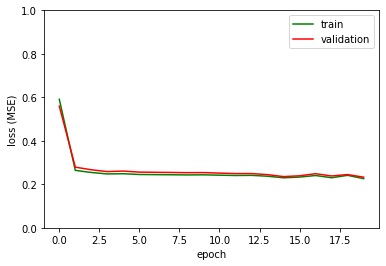

In [6]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
torch.manual_seed(42)

B=20 # batch size
lr = 0.1 # learning rate
iter=20 # number epochs

############################################ Reading Titanic numerical data, i.e., X and y
var_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
path=Path('/content/drive/MyDrive/AAA/Lesson_5/titanic_data') # adapt to your path
X,y=torch.load(path/'titanic_tensor_data_set.ts') # these values are not yet normalized
y=y[:,None] # to turn it into a column vector

##################################### Create train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

############################################## Ordinary least squares solution with 0.5 threshold
# variables to keep to avoid linear dependencies
var_keep=['Age', 'SibSp', 'Parch', 'LogFare', 'Sex_male',  'Pclass_1', 'Pclass_2',  'Embarked_C', 'Embarked_Q']
keep=np.isin(var_names,var_keep) # boolean list
# 
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train[:,keep], y_train)
print('coefficients MLR:',reg.intercept_,reg.coef_)
y_pred=reg.predict(X_valid[:,keep])
disp = ConfusionMatrixDisplay(confusion_matrix(y_valid,(y_pred>0.5)))
disp.plot()
plt.show()

####################################################### Gradient Descent
# if you want to standardize X and include an additional additive coefficient to the model:
if False: 
  means = X.mean(dim=1, keepdim=True)
  stds = X.std(dim=1, keepdim=True)
  X=normalized_data = (X - means) / stds
  # add column
  ones=torch.ones(X.shape[0]).reshape(X.shape[0],1)
  X=torch.cat((ones,X),1)
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# initial weights
def init_coeffs(n_coeff): return (torch.rand(n_coeff,1)-0.5).requires_grad_() # creates a column matrix
def init_coeffs(n_coeff):
    hiddens = [10, 8, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

# defining the function for prediction: the output is a vector of size=nrows(X)
def calc_preds(coeffs,X): return  torch.sigmoid(X@coeffs) # using matrix multiplication (aka matmul)
import torch.nn.functional as F
def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

# Computing MSE loss for one batch of exemples: the output is a scalar
def calc_loss_from_labels(y_pred, y): return torch.mean((y_pred - y) ** 2)

# update coeffs
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

# compute initial weights as a column matrix
n_coeff = X_train.shape[1] # number of columns of X, or X_train, or X_valid
coeffs = init_coeffs(n_coeff)

# create lists to store losses for each epoch
training_losses=[]; validation_losses=[]

# epochs
for i in range(iter):
  # calculating loss as in the beginning of an epoch and storing it
    y_pred = calc_preds(coeffs,X_train)
    training_losses.append(calc_loss_from_labels(y_pred, y_train).tolist())
    y_pred = calc_preds(coeffs,X_valid)
    validation_losses.append(calc_loss_from_labels(y_pred, y_valid).tolist())
    # mini-batch gradient descent: weight are updated after each batch
    for idx_start in np.arange(0,X_train.shape[0],B):
        # create batch
        batch_X=X_train[idx_start:(idx_start+B),:]
        batch_y=y_train[idx_start:(idx_start+B):]
        # making a prediction in forward pass
        y_pred = calc_preds(coeffs,batch_X)
        # calculating the loss between predicted and actual values
        loss = calc_loss_from_labels(y_pred, batch_y)
        # compute gradient
        loss.backward()
        with torch.no_grad():
            # update coeffs
            update_coeffs(coeffs, lr)

# predictions and confusion matrix
#print('coefficients GD:',torch.flatten(coeffs.requires_grad_(False)))
y_pred=calc_preds(coeffs,X_valid)
disp = ConfusionMatrixDisplay(confusion_matrix(y_valid,(y_pred>0.5)))
disp.plot()
plt.show()

# plot losses along epochs
plt.plot(training_losses, '-g',  validation_losses, '-r')
plt.gca().legend(('train','validation'))
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('loss (MSE)')
#plt.title("Train (green) and validation (red) losses")
plt.show()